# **AI IN BIOMEDICINE - FINAL ASSIGNMENT**

> **Authors of the notebook:** Pedro Gianjoppe, Alix de Langlais, Felipe Pascutti, Gianmarco Tardini

> **Goal:** In this homework, the objectif is to classify X-Ray images, which are divided into three categories: images of normal patients, images of tuberculosis patients, images of patients with pneumonia. The objective is also to perform XAI analysis to make the AI explainable. 

----


# **1. Introduction**

## 1.1 Set up the environment

In [ ]:
# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import logging
import shutil
import matplotlib.cm as cm
import sklearn
from numpy import expand_dims
from IPython.display import Image, display
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.cm as c_map
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from os import listdir
import matplotlib.image as mpimg
from matplotlib import rcParams

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## 1.2 Mount the *My Drive* folder

In [ ]:
#Link colab to the directories of a given google drive account
import os
from google.colab import drive
ROOT_PATH = os.path.join('/content/drive')
drive.mount(ROOT_PATH)

Mounted at /content/drive


In [ ]:
date_version = 'version_140123_v2'
%cd /content/drive/Shareddrives/Applied AI Project/Alix
%ls

/content/drive/Shareddrives/Applied AI Project/Alix
 AIProject_CNN_draft.ipynb   Dataset_130123/         'old - folders'/
 AIProject_CNN.ipynb         Dataset_140123/          predictions.zip
 baseline_030123.ipynb       hyperparameters.gsheet   reduced_df_030123.csv
 baseline_130123.ipynb       metrics.gsheet           train/
 CNN_output.csv              models_experiments/     'train 2'/
 Dataset_030123/            'old - code'/


## 1.3 Extract the files from the compressed archive

In [ ]:
'''import zipfile

with zipfile.ZipFile('/content/drive/Shareddrives/Applied AI Project/train_set_v2.zip','r') as zip_ref:
  zip_ref.extractall('/content/drive/Shareddrives/Applied AI Project/Alix/train 3')'''

## 1.4 Filtering

In [ ]:
def filtering(folder_path):
  count = 0
  for files in listdir(folder_path):

    if files == 'labels_train.csv':
      pass

    else:
      image = cv2.imread(str(folder_path + '/' + files)) # reads the image
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to HSV
      figure_size = 9 # the dimension of the x and y axis of the kernal.

      img_median = cv2.medianBlur(image,figure_size)
      img_gaussian = cv2.GaussianBlur(img_median, (figure_size,figure_size),0)

      os.remove(str(folder_path + '/' + files))
      path_filtered = str(folder_path + '/' + files)
      cv2.imwrite(path_filtered,img_gaussian)

      count +=1
      print(count)
      
  print('Total number of filtred images:', count)

In [ ]:
'''folder_path = 'train_filtered/train'
filtering(folder_path)'''

"folder_path = 'train_filtered/train'\nfiltering(folder_path)"

## 1.5 Standard Radiologic Background

In [ ]:
def my_contrast_stretch(img):
    if img.dtype == np.float64:
        img = (img * 255).astype(np.uint8)
    M=np.max(img)
    m=np.min(img)
    res = img - m
    res = res * (255 / (M - m))
    return res.astype(np.uint8)

In [ ]:
def invert_if_negative(folder_path):
    img = cv2.imread(folder_path, 0)
    img = my_contrast_stretch(img)
    # assuming image has fixed size of (1396, 1676)
    # corners
    top_left  = img[:6, :6].flatten()
    top_right = img[:6, 250:].flatten()
    # more or less center
    center    = img[126:130, 126:130].flatten()
    threshold = 200 # or computed from average
    top_left  = top_left > threshold
    top_right = top_right > threshold
    center    = center > threshold
    perc_white_corners = (sum(top_left) + sum(top_right)) / (len(top_left) + len(top_right))
    perc_white_center = sum(center) / len(center)

    if perc_white_corners < perc_white_center:
        img = 255 - img
        path_filtered = str(folder_path)
        #print('Path img filtered:', path_filtered)
        os.remove(str(folder_path))
        cv2.imwrite(path_filtered,img)

# **2. Data Loading**

## 2.1 Extract the information of the *.csv* file

In [ ]:
train_df = pd.read_csv('train 2/labels_train.csv')
train_df['label'] = train_df['label'].astype(str)
train_df.head()

,file,label
0,P07496_2.png,T
1,P07374_1.png,N
2,P07554_1.png,T
3,P07608_2.png,N
4,P07653_1.png,N




*   Column 1: the file name
*   Column 2: the class to which it belongs (N, P, or T)  
    *   N: normal patient
    *   P: patient with pneumonia
    *   T: patient with tuberculosis





In [ ]:
print('Dataset size:', train_df.shape)

Dataset size: (10588, 2)


## 2.2 Reduced dataset

In [ ]:
# As the dataset is too big, we choose to reduce its size

# 1. We put the file names and the associated label into two lists
img_file = []
img_label = []

for i in range (train_df.shape[0]):
  img_file.append(train_df.iat[i,0])
  img_label.append(train_df.iat[i,1])

# 2. We create three lists containing the file names associated to each class
normal_img = []
pneumonia_img = []
tuberculosis_img = []

for i in range(train_df.shape[0]):

  if img_label[i] == "N":
    normal_img.append(img_file[i])

  if img_label[i] == "T":
    tuberculosis_img.append(img_file[i])
  
  if img_label[i] == "P":
    pneumonia_img.append(img_file[i])
  
print('Number of images with tuberculosis:', len(tuberculosis_img))
print('Number of images of normal patient:', len(normal_img))
print('Number of images with pneumonia:', len(pneumonia_img))
print('Total images in the dataset', len(tuberculosis_img)+len(normal_img)+len(pneumonia_img))

Number of images with tuberculosis: 1272
Number of images of normal patient: 6399
Number of images with pneumonia: 2917
Total images in the dataset 10588


In [ ]:
# 3. We reduce the size of the class lists
red_normal_img = []
lbl_N = []
red_tuberculosis_img = []
lbl_T = []
red_pneumonia_img = []
lbl_P = []
size_class = 1200 #min(len(tuberculosis_img),len(normal_img),len(pneumonia_img))

red_normal_img = random.sample(normal_img, size_class)
lbl_N = ['N']*size_class

red_tuberculosis_img = random.sample(tuberculosis_img, size_class)
lbl_T = ['T']*size_class

red_pneumonia_img = random.sample(pneumonia_img, size_class)
lbl_P = ['P']*size_class

print('N:', len(red_normal_img),'P:', len(red_pneumonia_img),'T:', len(red_tuberculosis_img))

N: 1200 P: 1200 T: 1200


In [ ]:
# 4. We create the final list with the file names
final_file_img = []

i = 0
for i in range (len(red_normal_img)):
  final_file_img.append(red_normal_img [i])
i = 0
for i in range(len(red_tuberculosis_img)):
  final_file_img.append(red_tuberculosis_img[i])
i = 0
for i in range(len(red_pneumonia_img)):
  final_file_img.append(red_pneumonia_img[i])
  
print('Reduced dataset size:',len(final_file_img))

Reduced dataset size: 3600


In [ ]:
# 5. We create the final list with the label names
final_lbl = []
i = 0
for i in range (len(lbl_N)):
  final_lbl.append(lbl_N [i])
i = 0
for i in range(len(lbl_T)):
  final_lbl.append(lbl_T[i])
i = 0
for i in range(len(lbl_P)):
  final_lbl.append(lbl_P[i])

In [ ]:
# 6. We create the new dataframe
reduced_df_140123 = pd.DataFrame(list(zip(final_file_img, final_lbl)), columns = ['file', 'label'])
reduced_df_140123= sklearn.utils.shuffle(reduced_df_140123) # we randomize the dataframe
reduced_df_140123.head()

,file,label
1340,P04330_1.png,T
1601,P07051_1.png,T
3549,P10045_1.jpeg,P
3575,P06584_1.jpeg,P
211,P11092_2.png,N


In [ ]:
 # 7. We create the csv file corresponding to the reduced dataset
reduced_df_140123.to_csv('/content/drive/Shareddrives/Applied AI Project/Alix/reduced_df_140123.csv', index = False)

In [ ]:
print('Reduced dataset size:', reduced_df_140123.shape[0])
print(reduced_df_140123['label'].value_counts())

Reduced dataset size: 3600
T    1200
P    1200
N    1200
Name: label, dtype: int64


## 2.2 Split the dataset into train, validation, and test set

In [ ]:
pip install fast_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 5.8 MB/s eta 0:00:00




*   Train set: 80% of the dataset
*   validation set: 10% of the dataset
*   Test set: 10% of the dataset



In [ ]:
reduced_df_030123 = pd.read_csv('reduced_df_030123.csv')
reduced_df_030123['label'] = reduced_df_030123['label'].astype(str)
reduced_df_030123.head()

,file,label
0,P06112_1.jpeg,P
1,P06515_1.png,T
2,P11707_1.png,T
3,P12852_1.jpeg,P
4,P00650_1.png,T


In [ ]:
print('Reduced dataset size:', reduced_df_030123.shape[0])
print(reduced_df_030123['label'].value_counts())

Reduced dataset size: 3600
P    1200
T    1200
N    1200
Name: label, dtype: int64


In [ ]:
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(reduced_df_030123, target = 'label', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1,)

X_train_list = X_train.values.tolist()
y_train_list = y_train.values.tolist()

X_val_list = X_valid.values.tolist()
y_val_list = y_valid.values.tolist()

X_test_list = X_test.values.tolist()
y_test_list = y_test.values.tolist()

In [ ]:
x_train = []
y_train = []
N_train = 0
P_train = 0 
T_train = 0


x_val = []
y_val = []
N_val = 0
P_val = 0 
T_val = 0

x_test = []
y_test = []
N_test = 0
P_test = 0 
T_test = 0

i = 0
for i in range(X_train.shape[0]):
    x_train.append(X_train_list[i])
    y_train.append(y_train_list[i])
    if y_train_list[i] == "N":
      N_train += 1
    if y_train_list[i] == "P":
      P_train += 1
    if y_train_list[i] == "T":
      T_train += 1
    i += 1

for i in range(X_valid.shape[0]):
    x_val.append(X_val_list[i])
    y_val.append(y_val_list[i])
    if y_train_list[i] == "N":
      N_val += 1
    if y_train_list[i] == "P":
      P_val += 1
    if y_train_list[i] == "T":
      T_val += 1
    i += 1

for i in range(X_test.shape[0]):
    x_test.append(X_test_list[i])
    y_test.append(y_test_list[i])
    if y_train_list[i] == "N":
      N_test += 1
    if y_train_list[i] == "P":
      P_test += 1
    if y_train_list[i] == "T":
      T_test += 1
    i += 1

print('Total Images in the dataset: ', X_train.shape[0] + X_test.shape[0] + X_valid.shape[0])

#From list to tensor
x_train = np.asarray(x_train) 
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

#Some info
print('\nx_train shape: {}  y_train shape: {} \n Normal patient: {} \n Pneumonia patient: {} \n Tuberculosis patient: {}'.format(x_train.shape, y_train.size, N_train, P_train, T_train))
print('\nx_val shape: {}  y_val shape: {} \n Normal patient: {} \n Pneumonia patient: {} \n Tuberculosis patient: {}'.format(x_val.shape, y_val.size, N_val, P_val, T_val))
print('\nx_test shape: {}  y_test shape: {} \n Normal patient: {} \n Pneumonia patient: {} \n Tuberculosis patient: {}'.format(x_test.shape, y_test.size, N_test, P_test, T_test))

Total Images in the dataset:  3600

x_train shape: (2880, 1)  y_train shape: 2880 
 Normal patient: 943 
 Pneumonia patient: 958 
 Tuberculosis patient: 979

x_val shape: (360, 1)  y_val shape: 360 
 Normal patient: 107 
 Pneumonia patient: 126 
 Tuberculosis patient: 127

x_test shape: (360, 1)  y_test shape: 360 
 Normal patient: 107 
 Pneumonia patient: 126 
 Tuberculosis patient: 127


## 2.3 Creation of train, validation and test folders

### 2.3.1 Global folder

In [ ]:
datasetNameFolder = "Dataset_140123"

In [ ]:
''' 
Global data folder - Level 0
  Contain:
    - train set
    - validation set
    - test set
'''

if not os.path.exists(datasetNameFolder):
  os.mkdir(datasetNameFolder)

In [ ]:
''' 
Data set folder - Level 1
  Contain:
    - Training folder
    - Validation folder
    - Test folder
'''

if not os.path.exists(datasetNameFolder + "/training"): 
  os.mkdir(datasetNameFolder + "/training")
if not os.path.exists(datasetNameFolder + "/validation"):
  os.mkdir(datasetNameFolder + "/validation")
if not os.path.exists(datasetNameFolder + "/test"):
  os.mkdir(datasetNameFolder + "/test")

print("Depth 1 (Dataset folder)")
print("-------")
listdir(datasetNameFolder)

Depth 1 (Dataset folder)
-------


['training', 'validation', 'test']

### 2.3.2 Training folder

In [ ]:
''' 
Training data folder - Level 2
  Contain:
    - Pneumonia folder
    - Tuberculosis folder
    - Normal folder
'''

if not os.path.exists(datasetNameFolder + "/training/Normal"): # Normal patients folder
  os.mkdir(datasetNameFolder + "/training/Normal")
if not os.path.exists(datasetNameFolder + "/training/Tuberculosis"): # Tuberculosis patients folder
  os.mkdir(datasetNameFolder + "/training/Tuberculosis")
if not os.path.exists(datasetNameFolder + "/training/Pneumonia"): # Pneumonia patients folder
  os.mkdir(datasetNameFolder + "/training/Pneumonia")

print("Depth 2 (Training folder)")
print("-------")
listdir(datasetNameFolder + "/training")

Depth 2 (Training folder)
-------


['Normal', 'Tuberculosis', 'Pneumonia']

### 2.3.3 Validation folder

In [ ]:
''' 
Validation data folder - Level 2
  Contain:
    - Pneumonia folder
    - Tuberculosis folder
    - Normal folder
'''

if not os.path.exists(datasetNameFolder + "/validation/Normal"): # Normal patients folder
  os.mkdir(datasetNameFolder + "/validation/Normal")
if not os.path.exists(datasetNameFolder + "/validation/Tuberculosis"): # Tuberculosis patients folder
  os.mkdir(datasetNameFolder + "/validation/Tuberculosis")
if not os.path.exists(datasetNameFolder + "/validation/Pneumonia"): # Pneumonia patients folder
  os.mkdir(datasetNameFolder + "/validation/Pneumonia")

print("Depth 2 (Validation folder)")
print("-------")
listdir(datasetNameFolder + "/validation")

Depth 2 (Validation folder)
-------


['Normal', 'Tuberculosis', 'Pneumonia']

### 2.3.3 Test folder

In [ ]:
''' 
Test data folder - Level 2
  Contain:
    - Pneumonia folder
    - Tuberculosis folder
    - Normal folder
'''

if not os.path.exists(datasetNameFolder + "/test/Normal"): # Normal patients folder
  os.mkdir(datasetNameFolder + "/test/Normal")
if not os.path.exists(datasetNameFolder + "/test/Tuberculosis"): # Tuberculosis patients folder
  os.mkdir(datasetNameFolder + "/test/Tuberculosis")
if not os.path.exists(datasetNameFolder + "/test/Pneumonia"): # Pneumonia patients folder
  os.mkdir(datasetNameFolder + "/test/Pneumonia")

print("Depth 2 (Test folder)")
print("-------")
listdir(datasetNameFolder + "/test")

Depth 2 (Test folder)
-------


['Normal', 'Tuberculosis', 'Pneumonia']

## 2.4 Import of images into the corresponding folders

In [ ]:
import shutil 

DATASET_PATH = "train 2" 
FINAL_DATASET_PATH = datasetNameFolder

 ### 2.4.1 Training folder

In [ ]:
train_count = 0
missing = 0

for i in range(X_train.shape[0]):

  img = X_train.iat[i,0]
  lbl = y_train[i]
  
  if lbl == 'N':
    destination = os.path.join(FINAL_DATASET_PATH,"training", "Normal")
  if lbl == 'P':
    destination = os.path.join(FINAL_DATASET_PATH,"training", "Pneumonia")
  if lbl == 'T':
    destination = os.path.join(FINAL_DATASET_PATH,"training", "Tuberculosis")
  
  img_to_copy = os.path.join(DATASET_PATH,img)

  if not os.path.exists(img_to_copy):
      pass
      missing += 1

  else:
      shutil.copy(img_to_copy, destination)
  
  train_count += 1
  #print(train_count)

print("Train count: ", train_count)
print("Missing images: ", missing)

Train count:  2880
Missing images:  0


In [ ]:
normal_img = 0
dir = datasetNameFolder + "/training/Normal"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        normal_img += 1

print("Number of images for normal patient: ", normal_img)

pneumonia_img = 0
dir = datasetNameFolder + "/training/Pneumonia"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        pneumonia_img += 1

print("Number of images for pneumonia patient: ", pneumonia_img)

tuberculosis_img = 0
dir = datasetNameFolder + "/training/Tuberculosis"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        tuberculosis_img += 1

print("Number of images for normal patient: ", tuberculosis_img)

tot_img_train = normal_img + pneumonia_img + tuberculosis_img

print("Total number of images in the training folder:", tot_img_train)

Number of images for normal patient:  943
Number of images for pneumonia patient:  958
Number of images for normal patient:  979
Total number of images in the training folder: 2880


In [ ]:
test_path_P = datasetNameFolder + "/training/Pneumonia"
for files in listdir(test_path_P):
  img_path = os.path.join(test_path_P,files)
  invert_if_negative(img_path)

test_path_N = datasetNameFolder + "/training/Normal"
for files in listdir(test_path_N):
  img_path = os.path.join(test_path_N,files)
  invert_if_negative(img_path)

test_path_T = datasetNameFolder + "/training/Tuberculosis"
for files in listdir(test_path_T):
  img_path = os.path.join(test_path_T,files)
  invert_if_negative(img_path)

### 2.4.2 Validation folder

In [ ]:
valid_count = 0
missing = 0

for i in range(X_valid.shape[0]):

  img = X_valid.iat[i,0]
  lbl = y_val[i]
  
  if lbl == 'N':
    destination = os.path.join(FINAL_DATASET_PATH,"validation", "Normal")
  if lbl == 'P':
    destination = os.path.join(FINAL_DATASET_PATH,"validation", "Pneumonia")
  if lbl == 'T':
    destination = os.path.join(FINAL_DATASET_PATH,"validation", "Tuberculosis")
  
  img_to_copy = os.path.join(DATASET_PATH,img)

  
  if not os.path.exists(img_to_copy):
      pass
      missing += 1
  else:
      shutil.copy(img_to_copy, destination)
  valid_count += 1
  #print(valid_count)
  
print("Train count: ", valid_count)
print("Missing images: ", missing)

Train count:  360
Missing images:  0


In [ ]:
normal_img = 0
dir = datasetNameFolder + "/validation/Normal"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        normal_img += 1
print("Number of images for normal patient: ", normal_img)

pneumonia_img = 0
dir = datasetNameFolder + "/validation/Pneumonia"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        pneumonia_img += 1
print("Number of images for pneumonia patient: ", pneumonia_img)

tuberculosis_img = 0
dir = datasetNameFolder + "/validation/Tuberculosis"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        tuberculosis_img += 1
print("Number of images for normal patient: ", tuberculosis_img)

tot_img_val = normal_img + pneumonia_img + tuberculosis_img

print("Total number of images in the validation folder:", tot_img_val)

Number of images for normal patient:  128
Number of images for pneumonia patient:  119
Number of images for normal patient:  113
Total number of images in the validation folder: 360


In [ ]:
test_path_P = datasetNameFolder + "/validation/Pneumonia"
for files in listdir(test_path_P):
  img_path = os.path.join(test_path_P,files)
  invert_if_negative(img_path)

test_path_N = datasetNameFolder + "/validation/Normal"
for files in listdir(test_path_N):
  img_path = os.path.join(test_path_N,files)
  invert_if_negative(img_path)

test_path_T = datasetNameFolder + "/validation/Tuberculosis"
for files in listdir(test_path_T):
  img_path = os.path.join(test_path_T,files)
  invert_if_negative(img_path)

### 2.4.3 Test folder

In [ ]:
train_count = 0
missing = 0

for i in range(X_test.shape[0]):

  img = X_test.iat[i,0]
  lbl = y_test[i]
  
  if lbl == 'N':
    destination = os.path.join(FINAL_DATASET_PATH,"test", "Normal")
  if lbl == 'P':
    destination = os.path.join(FINAL_DATASET_PATH,"test", "Pneumonia")
  if lbl == 'T':
    destination = os.path.join(FINAL_DATASET_PATH,"test", "Tuberculosis")
  
  img_to_copy = os.path.join(DATASET_PATH,img)
  
  if not os.path.exists(img_to_copy):
      pass
      missing += 1
  else:
      shutil.copy(img_to_copy, destination)
  train_count += 1
  #print(train_count)
  
print("Train count: ", train_count)
print("Missing images: ", missing)

Train count:  360
Missing images:  0


In [ ]:
normal_img = 0
dir = datasetNameFolder + "/test/Normal"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        normal_img += 1
print("Number of images for normal patient: ", normal_img)

pneumonia_img = 0
dir = datasetNameFolder + "/test/Pneumonia"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        pneumonia_img += 1
print("Number of images for pneumonia patient: ", pneumonia_img)

tuberculosis_img = 0
dir = datasetNameFolder + "/test/Tuberculosis"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        tuberculosis_img += 1
print("Number of images for normal patient: ", tuberculosis_img)

tot_img_test = normal_img + pneumonia_img + tuberculosis_img

print("Total number of images in the test folder:", tot_img_test)

Number of images for normal patient:  129
Number of images for pneumonia patient:  123
Number of images for normal patient:  108
Total number of images in the test folder: 360


In [ ]:
test_path_P = datasetNameFolder + "/test/Pneumonia"
for files in listdir(test_path_P):
  img_path = os.path.join(test_path_P,files)
  invert_if_negative(img_path)

test_path_N = datasetNameFolder + "/test/Normal"
for files in listdir(test_path_N):
  img_path = os.path.join(test_path_N,files)
  invert_if_negative(img_path)

test_path_T = datasetNameFolder + "/test/Tuberculosis"
for files in listdir(test_path_T):
  img_path = os.path.join(test_path_T,files)
  invert_if_negative(img_path)

## 2.5 Plot images of the dataset

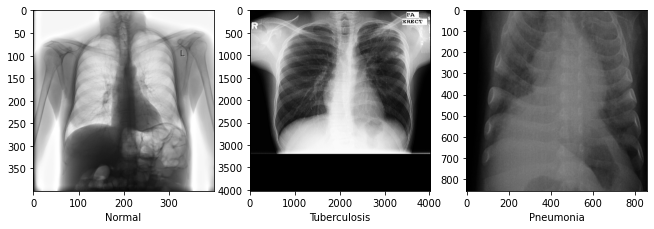

In [ ]:
img_N = mpimg.imread(datasetNameFolder + '/training/Normal/' + listdir(datasetNameFolder + '/training/Normal/')[0])
img_T = mpimg.imread(datasetNameFolder + '/training/Tuberculosis/' + listdir(datasetNameFolder + '/training/Tuberculosis/')[1])
img_P = mpimg.imread(datasetNameFolder + '/training/Pneumonia/' + listdir(datasetNameFolder + '/training/Pneumonia/')[1])

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

fig, ax = plt.subplots(1,3)
ax[0].imshow(cv2.cvtColor(img_N, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img_T, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(img_P, cv2.COLOR_BGR2RGB))

ax[0].set_xlabel('Normal')
ax[1].set_xlabel('Tuberculosis')
ax[2].set_xlabel('Pneumonia')

plt.show()


# **3. Data Augmentation**

## 3.1 Directories creation

In [ ]:
# Creation of a directory for the augmented images
if not os.path.exists(datasetNameFolder + "/augmentation"):
  os.mkdir(datasetNameFolder + "/augmentation")
  print("Creation of a folder for the augmented images.")
else:
  print("The folder for augmented images already exists.")

Creation of a folder for the augmented images.


In [ ]:
# Creation of sub-folders for each class N, P or T

# Normal patients directory 
if not os.path.exists(datasetNameFolder + "/augmentation/Normal"):
  os.mkdir(datasetNameFolder + "/augmentation/Normal")
  print("Creation of a folder for the normal patients images.")
else:
  print("The folder for normal patients images already exists.")

# Tuberculosis directory
if not os.path.exists(datasetNameFolder + "/augmentation/Tuberculosis"):
  os.mkdir(datasetNameFolder + "/augmentation/Tuberculosis")
  print("Creation of a folder for the tuberculosis patients images.")
else:
  print("The folder for tuberculosis patients images already exists.")

# Pneumonia directory
if not os.path.exists(datasetNameFolder + "/augmentation/Pneumonia"):
  os.mkdir(datasetNameFolder + "/augmentation/Pneumonia")
  print("Creation of a folder for the pneumonia patients images.")
else:
  print("The folder for pneumonia patients images already exists.")

Creation of a folder for the normal patients images.
Creation of a folder for the tuberculosis patients images.
Creation of a folder for the pneumonia patients images.


## 3.2 *Are the directories empty?*

In [ ]:
# Check that the directory is empty. If not, delete the files

# Normal patients directory 
if len(os.listdir(datasetNameFolder + '/augmentation/Normal')) == 0:
  print("The directory for normal patients images is empty.")

else:    
  print("The directory for normal patients images is not empty.")
  files = os.listdir(datasetNameFolder + '/augmentation/Normal')
  for i in range(len(files)):
    os.remove(datasetNameFolder + '/augmentation/Normal' +'/'+files[i])
  print("Number of files remaining in the Normal directory: ", len(os.listdir(datasetNameFolder + '/augmentation/Normal')))

# Tuberculosis patients directory 
if len(os.listdir(datasetNameFolder + '/augmentation/Tuberculosis')) == 0:
  print("The directory for tuberculosis patients images is empty.")

else:    
  print("The directory for tuberculosis patients images is not empty.")
  files = os.listdir(datasetNameFolder + '/augmentation/Tuberculosis')
  for i in range(len(files)):
    os.remove(datasetNameFolder + '/augmentation/Tuberculosis' +'/'+files[i])
  print("Number of files remaining in the Tuberculosis directory: ", len(os.listdir(datasetNameFolder + '/augmentation/Tuberculosis')))

# Pneumonia patients directory 
if len(os.listdir(datasetNameFolder + '/augmentation/Pneumonia')) == 0:
  print("The directory for pneumonia patients images is empty.")

else:    
  print("The directory for Pneumonia patients images is not empty.")
  files = os.listdir(datasetNameFolder + '/augmentation/Pneumonia')
  for i in range(len(files)):
    os.remove(datasetNameFolder + '/augmentation/Pneumonia' +'/'+files[i])
  print("Number of files remaining in the Pneumonia directory: ", len(os.listdir(datasetNameFolder + '/augmentation/Pneumonia')))

The directory for normal patients images is empty.
The directory for tuberculosis patients images is empty.
The directory for pneumonia patients images is empty.


## 3.3 Copy of the training images

In [ ]:
# Once the directory is cleared, copy the training images 

# Normal directory 
files_N = os.listdir(datasetNameFolder + '/training/Normal')
for i in range (len(files_N)):
  shutil.copy(datasetNameFolder + '/training/Normal/'+ files_N[i], datasetNameFolder + '/augmentation/Normal')
print('Nb of files in the original Normal directory:', len(files_N))
print('Nb of files in the copied Normal directory:', len(os.listdir(datasetNameFolder + '/augmentation/Normal')))

# Pneumonia directory 
files_P = os.listdir(datasetNameFolder + '/training/Pneumonia')
for i in range (len(files_P)):
  shutil.copy(datasetNameFolder + '/training/Pneumonia/'+ files_P[i], datasetNameFolder + '/augmentation/Pneumonia')
print('\nNb of files in the original Pneumonia directory:', len(files_P))
print('Nb of files in the copied Pneumonia directory:', len(os.listdir(datasetNameFolder + '/augmentation/Pneumonia')))

# Tuberculosis directory 
files_T = os.listdir(datasetNameFolder + '/training/Tuberculosis')
for i in range (len(files_T)):
  shutil.copy(datasetNameFolder + '/training/Tuberculosis/'+ files_T[i], datasetNameFolder + '/augmentation/Tuberculosis')
print('\nNb of files in the original Tuberculosis directory:', len(files_T))
print('Nb of files in the copied Tuberculosis directory:', len(os.listdir(datasetNameFolder + '/augmentation/Tuberculosis')))

Nb of files in the original Normal directory: 943
Nb of files in the copied Normal directory: 943

Nb of files in the original Pneumonia directory: 958
Nb of files in the copied Pneumonia directory: 958

Nb of files in the original Tuberculosis directory: 979
Nb of files in the copied Tuberculosis directory: 979


## 3.4 Augmentation functions

### 3.4.1 Rescale

In [ ]:
def rescale(img_path):
  '''
  image = load_img(img_path)

  image_new = image
  dataImage = img_to_array(image_new)

  imageRescaled = expand_dims(dataImage, 0)
  imageDataGen = ImageDataGenerator(zoom_range=[0.7,1.0])
  iterator = imageDataGen.flow(imageRescaled, batch_size=1)

  batch = iterator.next()
  imgRescaled = batch[0].astype('uint8')
  
  # Creation of the file name
  path_img_rescaled = img_path.split('.')
  path_img_rescaled.insert(1,'_rescaled.')
  path_img_rescaled = ''.join(path_img_rescaled)

  # Save the augmented image
  cv2.imwrite(path_img_rescaled,imgRescaled)
  '''
  image_original = load_img(img_path)
  image = image_original

  dataImage = img_to_array(image)

  imageRescaled = expand_dims(dataImage, 0)
  imageDataGen = ImageDataGenerator(zoom_range=[0.7,1.0])
  iterator = imageDataGen.flow(imageRescaled, batch_size=1)

  batch = iterator.next()
  imgRescaled = batch[0].astype('uint8')
  
  # Creation of the file name
  path_img_rescaled = img_path.split('.')
  path_img_rescaled.insert(1,'_rescaled.')
  path_img_rescaled = ''.join(path_img_rescaled)

  # Save the augmented image
  #os.remove(img_path)
  cv2.imwrite(path_img_rescaled,imgRescaled)

### 3.4.2 Rotation

In [ ]:
def rotation (img_path, max_angle):

  image_original = load_img(img_path)
  image = image_original

  dataImage = img_to_array(image)

  imageRotated = expand_dims(image, 0)
  imageDataGen = ImageDataGenerator(rotation_range = max_angle)
  iterator = imageDataGen.flow(imageRotated, batch_size=1)

  batch = iterator.next()
  imgRotated = batch[0].astype('uint8')

  # Creation of the file name
  path_img_rotated = img_path.split('.')
  path_img_rotated.insert(1,'_rotated.')
  path_img_rotated = ''.join(path_img_rotated)

  # Save the augmented image
  #os.remove(img_path)
  cv2.imwrite(path_img_rotated,imgRotated)


### 3.4.3 Shift

In [ ]:
def shift (img_path):
  '''
  image = load_img(img_path)

  image_new = image
  dataImage = img_to_array(image_new)

  imgShifted = expand_dims(image_new, 0)
  imageDataGen = ImageDataGenerator(width_shift_range=[-50,50])
  iterator = imageDataGen.flow(imgShifted, batch_size=1)

  batch = iterator.next()
  imgShifted = batch[0].astype('uint8')
  
  # Creation of the file name
  path_img_shifted = img_path.split('.')
  path_img_shifted.insert(1,'_shifted.')
  path_img_shifted = ''.join(path_img_shifted)

  # Save the augmented image
  cv2.imwrite(path_img_shifted,imgShifted)
  '''
  image_original = load_img(img_path)
  image = image_original

  dataImage = img_to_array(image)

  imgShifted = expand_dims(image, 0)
  imageDataGen = ImageDataGenerator(width_shift_range=[-50,50])
  iterator = imageDataGen.flow(imgShifted, batch_size=1)

  batch = iterator.next()
  imgShifted = batch[0].astype('uint8')
  
  # Creation of the file name
  path_img_shifted = img_path.split('.')
  path_img_shifted.insert(1,'_shifted.')
  path_img_shifted = ''.join(path_img_shifted)

  # Save the augmented image
  #os.remove(img_path)
  cv2.imwrite(path_img_shifted,imgShifted)

### 3.4.4 Add noise

In [ ]:
import random

def add_noise(img):
    
    # Getting the dimensions of the image
    row , col = img.shape
     
    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
         
        # Color that pixel to white
        img[y_coord][x_coord] = 255
         
    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
         
        # Color that pixel to black
        img[y_coord][x_coord] = 0
         
    return img

In [ ]:
def salt_pepper(img_path):

  image_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  img = np.array(image_original)

  # Creation of the file name
  path_img_noise = img_path.split('.')
  path_img_noise.insert(1,'_noise.')
  path_img_noise = ''.join(path_img_noise)

  cv2.imwrite(path_img_noise, add_noise(img))

### 3.4.4 Combination

In [ ]:
def mixAug(img_path, max_angle):
  image_original = load_img(img_path)
  image = image_original

  dataImage = img_to_array(image)

  imgMixed = expand_dims(image, 0)
  imageDataGen = ImageDataGenerator(
      width_shift_range=[-50,50],
      rotation_range = max_angle,
      zoom_range=[0.7,1.0]
      )
  iterator = imageDataGen.flow(imgMixed, batch_size=1)

  batch = iterator.next()
  imgMixed = batch[0].astype('uint8')
  
  # Creation of the file name
  path_img_mixed = img_path.split('.')
  path_img_mixed.insert(1,'_mixed.')
  path_img_mixed = ''.join(path_img_mixed)

  # Save the augmented image
  cv2.imwrite(path_img_mixed,imgMixed)

In [ ]:
def augmentation (img_path, max_angle):
  val = np.random.choice (np.array([1,2,3,4,5]))
  
  if val == 1 :
    rescale(img_path)
  if val == 2:
    shift(img_path)
  if val == 3:
    rotation(img_path, max_angle)
  if val == 4:
    mixAug(img_path, max_angle)
  
  if val == 5:
    salt_pepper(img_path)

## 3.5 Data Augmentation

In [ ]:
# Augmentation for the normal images
files_N = os.listdir(datasetNameFolder + '/augmentation/Normal')
i = 0
for i in range (0,len(files_N)):
  #print(i)
  path_file = datasetNameFolder + '/augmentation/Normal/'+files_N[i]
  augmentation(path_file,20)
print("Number of files before augmentation in the Normal directory: ", len(files_N))
print("Number of files after augmentation in the Normal directory: ", len(os.listdir(datasetNameFolder + '/augmentation/Normal')))

# Augmentation for the tuberculosis images
files_T = os.listdir(datasetNameFolder + '/augmentation/Tuberculosis')
i = 0
for i in range (0,len(files_T)):
  #print(i)
  path_file = datasetNameFolder + '/augmentation/Tuberculosis/'+files_T[i]
  augmentation(path_file,20)
print("\nNumber of files before augmentation in the Tuberculosis directory: ", len(files_T))
print("Number of files after augmentation in the Tuberculosis directory: ", len(os.listdir(datasetNameFolder + '/augmentation/Tuberculosis')))

# Augmentation for the pneumonia images
files_P = os.listdir(datasetNameFolder + '/augmentation/Pneumonia')
i = 0
for i in range (0,len(files_P)):
  #print(i)
  path_file = datasetNameFolder + '/augmentation/Pneumonia/'+files_P[i]
  augmentation(path_file,20)
print("\nNumber of files before augmentation in the Pneumonia directory: ", len(files_P))
print("Number of files after augmentation in the Pneumonia directory: ", len(os.listdir(datasetNameFolder + '/augmentation/Pneumonia')))

Number of files before augmentation in the Normal directory:  943
Number of files after augmentation in the Normal directory:  1886

Number of files before augmentation in the Tuberculosis directory:  979
Number of files after augmentation in the Tuberculosis directory:  1958

Number of files before augmentation in the Pneumonia directory:  958
Number of files after augmentation in the Pneumonia directory:  1916


# **4. Data Loader - Image Data Generator**

In [ ]:
# Dataset folders 
dataset_dir = datasetNameFolder
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir,'test')
augmentation_dir = os.path.join(dataset_dir, 'augmentation')

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

labels = ['Normal',   
          'Pneumonia',   
          'Tuberculosis']
          
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=augmentation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=labels, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 5760 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
Found 360 images belonging to 3 classes.


In [ ]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Normal': 0, 'Pneumonia': 1, 'Tuberculosis': 2}

Target classes
[0 0 0 ... 2 2 2]


In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 3)

Categorical label: [0. 0. 1.]
Label: 2
Class name: Tuberculosis


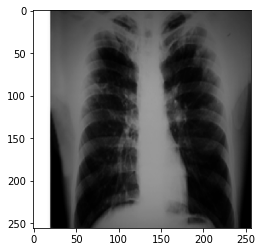

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

# **5. Build model**

In [ ]:
# Model netadata
input_shape = (256, 256, 3)
epochs = 200

In [ ]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

# **6. Train the model**

In [ ]:
# Create folders and callbacks and fit
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'auto', patience=15, restore_best_weights = True)

# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = callbacks,
).history

Epoch 1/200
720/720 [==============================] - 126s 163ms/step - loss: 26.3245 - accuracy: 0.5139 - val_loss: 0.7835 - val_accuracy: 0.6333
Epoch 2/200
720/720 [==============================] - 113s 157ms/step - loss: 0.9240 - accuracy: 0.5681 - val_loss: 0.7067 - val_accuracy: 0.6750
Epoch 3/200
720/720 [==============================] - 113s 156ms/step - loss: 0.8377 - accuracy: 0.6207 - val_loss: 0.6350 - val_accuracy: 0.7222
Epoch 4/200
720/720 [==============================] - 113s 156ms/step - loss: 0.7698 - accuracy: 0.6509 - val_loss: 0.5744 - val_accuracy: 0.7361
Epoch 5/200
720/720 [==============================] - 112s 156ms/step - loss: 0.7561 - accuracy: 0.6628 - val_loss: 0.5617 - val_accuracy: 0.7500
Epoch 6/200
720/720 [==============================] - 112s 156ms/step - loss: 0.7253 - accuracy: 0.6668 - val_loss: 0.7389 - val_accuracy: 0.7306
Epoch 7/200
720/720 [==============================] - 113s 157ms/step - loss: 0.7381 - accuracy: 0.6780 - val_loss: 

In [ ]:
# Save best epoch model
str_directory = os.path.join('models_experiments','Experiments_' + date_version + '/CNN_' + date_version + '_Best')
model.save(str_directory)

In [ ]:
str_directory = "models_experiments/Experiments_version_140123_v2/CNN_version_140123_v2_Best"
model = tfk.models.load_model(str_directory)

normal_path = datasetNameFolder + "/test/Normal" 
pneumonia_path = datasetNameFolder + "/test/Pneumonia" 
tuberculosis_path = datasetNameFolder + "/test/Tuberculosis"

def format_output(test_path, model):
  '''
  input: 
  - test_path (where the test dataset is located)
  - model (the model that are being used)
  - save_path (where to save the csv file) -> format: 'desired_path/file_name.csv'

  output:
  - save the csv file
  - panda df
  '''
  def image_to_np(image_path, size):
    '''
    Function to transform an image numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img) # Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,256,256,3)
    
    return img
  
  df_prediction = pd.DataFrame(columns=['file','label'])

  for files in listdir(test_path):
    img_path = os.path.join(test_path,files)
    img_np = image_to_np(img_path, (256, 256))
    prediction = model.predict(img_np)[0].tolist()  #produces an array [x,y,z] x = P(Normal), y = P(Pneumonia), z = P(Tuberculosis)
    
    if max(prediction) == prediction[0]: # Normal
      label = "N"
    elif max(prediction) == prediction[1]: # Pneumonia
      label = "P"
    elif max(prediction) == prediction[2]: # Tuberculosis
      label = "T"

    new_row = {'file':files, 'label':label}
    #append row to the dataframe
    df_prediction = df_prediction.append(new_row, ignore_index=True)

  #df_prediction.to_csv(save_path, index=False)

  return df_prediction

df_N = format_output(normal_path, model)
df_T = format_output(tuberculosis_path, model)
df_P = format_output(pneumonia_path, model)


1/1 [==============================] - 0s 37ms/step


In [ ]:
save_path = "/content/drive/Shareddrives/Applied AI Project/Alix/CNN_output.csv"

df_results = pd.concat([df_N, df_P, df_T])
df_results.to_csv(save_path, index=False)

# 7. Evaluation of the model on the test

## 7.1 Test metrics

In [ ]:
# Evaluate on test
#str_directory = os.path.join('models_experiments','Experiments_' + date_version + '/CNN_' + date_version + '_Best')

str_directory = "models_experiments/Experiments_version_140123_v2/CNN_version_140123_v2_Best"
model = tfk.models.load_model(str_directory)


In [ ]:
model_test_metrics = model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics with data augmentation")
print(model_test_metrics)


45/45 [==============================] - 57s 1s/step - loss: 0.3881 - accuracy: 0.9222

Test metrics with data augmentation
{'loss': 0.3880641460418701, 'accuracy': 0.9222221970558167}


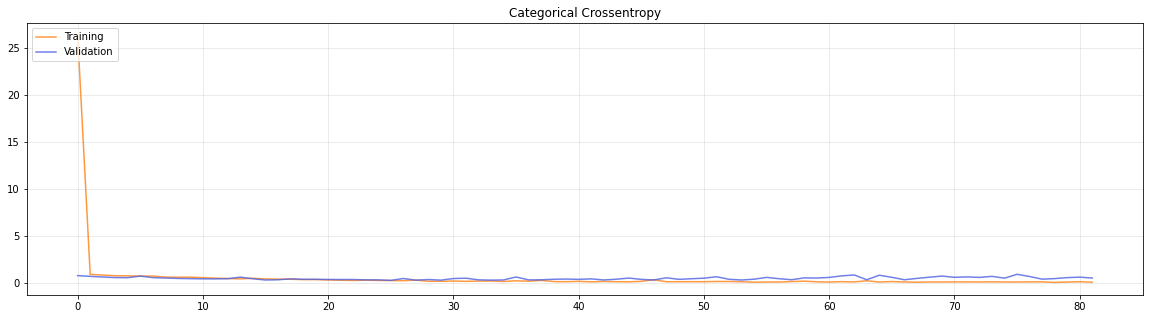

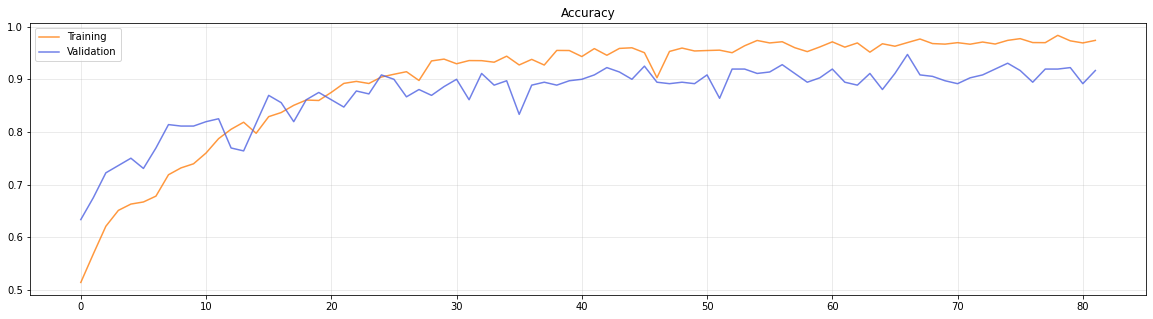

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 7.2 Confusion matrix

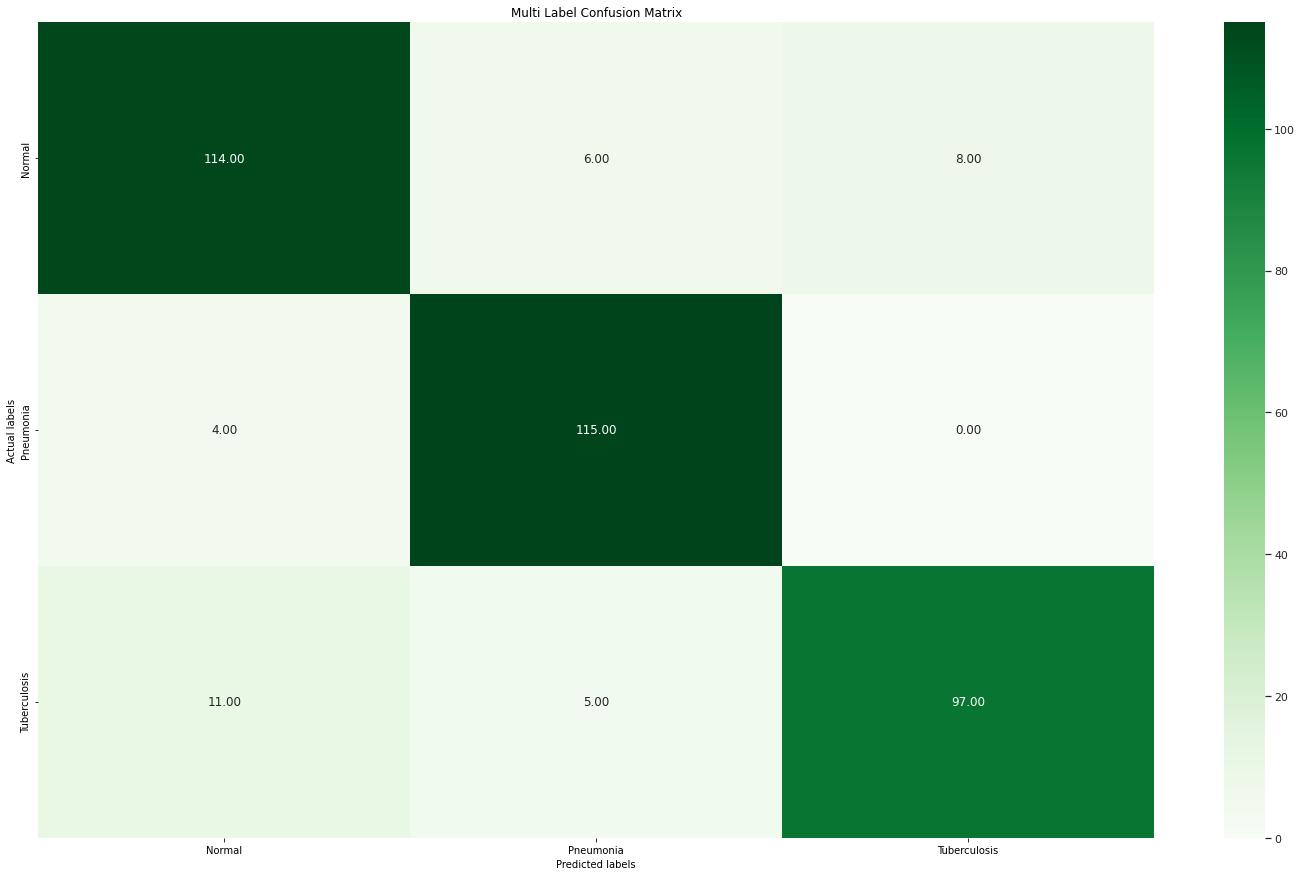

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict the values from the validation dataset
Y_pred = model.predict_generator(test_gen)

classes_name = labels

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = valid_gen.classes,y_pred = Y_pred_classes)

plt.figure(figsize = (25,15))
plt.title("Multi Label Confusion Matrix")

sns.set(font_scale=1.)
sns.heatmap(confusion_mtx, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True,fmt='.2f')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

## 7.3 Classification report

In [ ]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(
    test_gen.classes,
    Y_pred_classes,
    target_names = sorted(os.listdir(training_dir))))

              precision    recall  f1-score   support

      Normal       0.89      0.89      0.89       129
   Pneumonia       0.95      0.98      0.96       123
Tuberculosis       0.92      0.90      0.91       108

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360



In [ ]:
report = classification_report(
    test_gen.classes,
    Y_pred_classes,
    target_names = sorted(os.listdir(training_dir)), output_dict = True)

accuracy = report['accuracy']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
global_f1 = report['macro avg']['f1-score']
normal_f1 = report['Normal']['f1-score']
pneumonia_f1 = report['Pneumonia']['f1-score']
tuberculosis_f1 = report['Tuberculosis']['f1-score']

CNN_metrics = {
    'Test accuracy' : accuracy,
    'Precision' : precision,
    'Recall' : recall,
    'Global F1' : global_f1,
    'F1 Normal' : normal_f1,
    'F1 Tuberculosis' : tuberculosis_f1,
    'F1 Pneumonia' : pneumonia_f1,
}

df_metrics = pd.DataFrame([CNN_metrics],index={'CNN':'0'})
display(df_metrics)

,Test accuracy,Precision,Recall,Global F1,F1 Normal,F1 Tuberculosis,F1 Pneumonia
CNN,0.922222,0.922554,0.921744,0.922042,0.891473,0.910798,0.963855


# **8. XAI**

## 8.1 Grad-CAM

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimposed_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [ ]:
IMG_SIZE = (256, 256)
last_conv_layer_name = "conv2d_4"
model.layers[-1].activation = None
model.layers[-2].activation = None
model.layers[-3].activation = None
model.layers[-4].activation = None

In [ ]:
%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

test_path = datasetNameFolder + "/test/Pneumonia"
i = 0
for files in listdir(test_path):
  
  img_path = os.path.join(test_path,files)
  img_array = preprocess_input(get_img_array(img_path, size=IMG_SIZE))
  
  # Read images
  img_original = mpimg.imread(img_path)

  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  img_HM = superimposed_gradcam(img_path, heatmap)

  # display images
  print("\033[92m \033[1m Img Pneumonia: {} ↓ \033[0m".format(files))
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
  ax[0].set_xlabel('Original')
  ax[1].imshow(img_HM)
  ax[1].set_xlabel('Heatmap / Grad-CAM')
  fig.suptitle('Class: Pneumonia')
  plt.show()
  i+=1
  if i > 100: break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

test_path = datasetNameFolder + "/test/Tuberculosis"
i = 0
for files in listdir(test_path):
  
  img_path = os.path.join(test_path,files)
  img_array = preprocess_input(get_img_array(img_path, size=IMG_SIZE))
  
  # Read images
  img_original = mpimg.imread(img_path)

  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  img_HM = superimposed_gradcam(img_path, heatmap)

  # display images
  print("\033[92m \033[1m Img Tuberculosis: {} ↓ \033[0m".format(files))
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
  ax[0].set_xlabel('Original')
  ax[1].imshow(img_HM)
  ax[1].set_xlabel('Heatmap / Grad-CAM')
  fig.suptitle('Class: Tuberculosis')
  plt.show()
  i+=1
  if i > 100: break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

test_path = datasetNameFolder + "/test/Normal"
i = 0
for files in listdir(test_path):
  
  img_path = os.path.join(test_path,files)
  img_array = preprocess_input(get_img_array(img_path, size=IMG_SIZE))
  
  # Read images
  img_original = mpimg.imread(img_path)

  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  img_HM = superimposed_gradcam(img_path, heatmap)

  # display images
  print("\033[92m \033[1m Img Normal: {} ↓ \033[0m".format(files))
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
  ax[0].set_xlabel('Original')
  ax[1].imshow(img_HM)
  ax[1].set_xlabel('Heatmap / Grad-CAM')
  plt.show()
  fig.suptitle('Class: Normal')
  i+=1
  if i > 100: break

Output hidden; open in https://colab.research.google.com to view.

## 8.2 Bar plot

In [ ]:
def image_to_np(image_path, size):
    '''
    Function to transform an image numpy array
    '''
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,256,256,3)
    
    return img

1/1 [==============================] - 0s 57ms/step


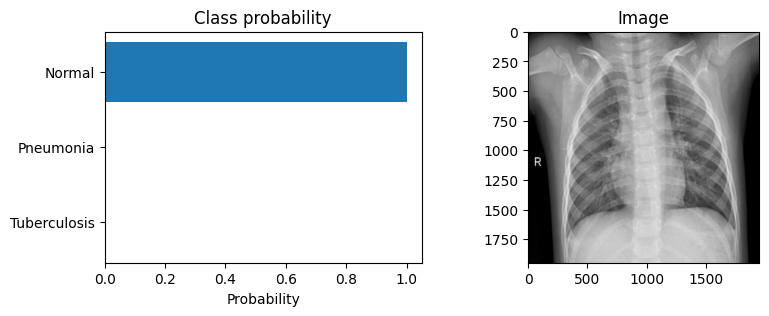

1/1 [==============================] - 0s 40ms/step


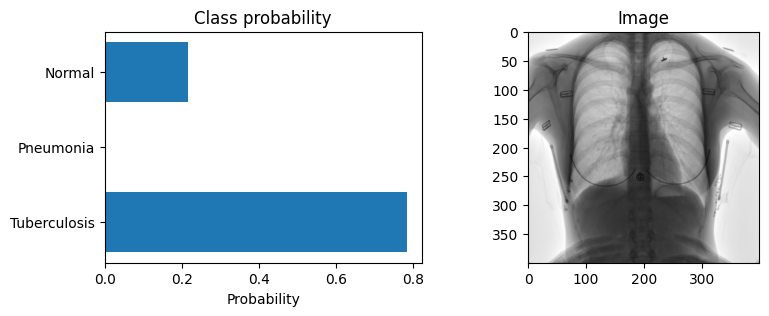

1/1 [==============================] - 0s 72ms/step


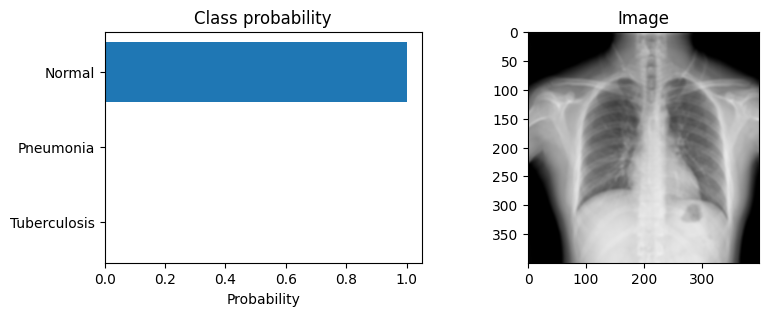

1/1 [==============================] - 0s 40ms/step


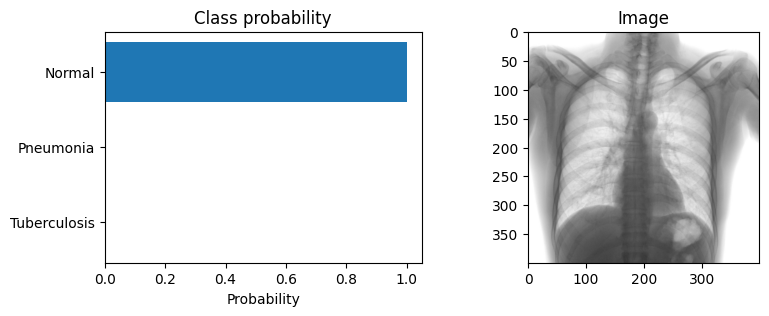

1/1 [==============================] - 0s 31ms/step


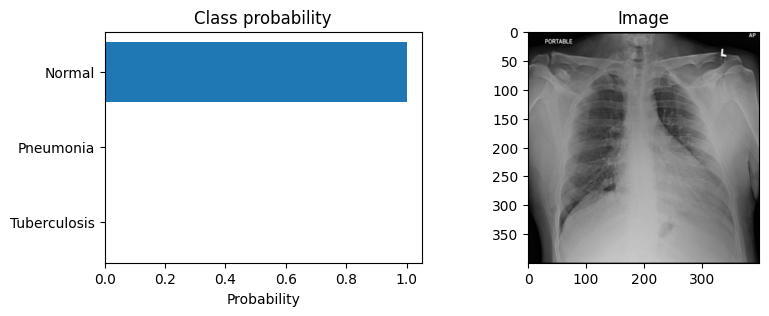

1/1 [==============================] - 0s 26ms/step


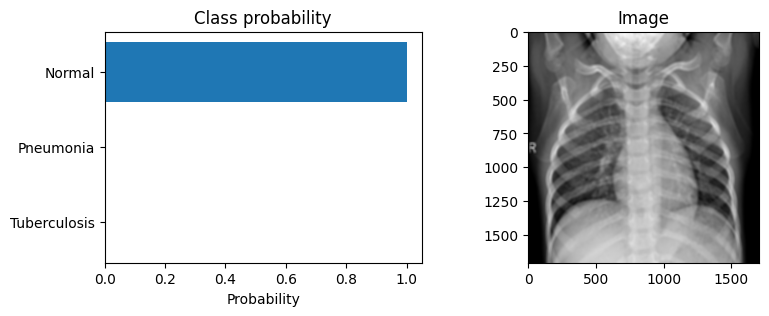

1/1 [==============================] - 0s 18ms/step


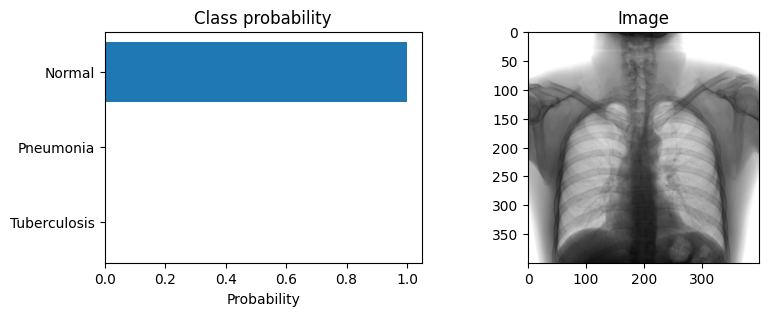

1/1 [==============================] - 0s 20ms/step


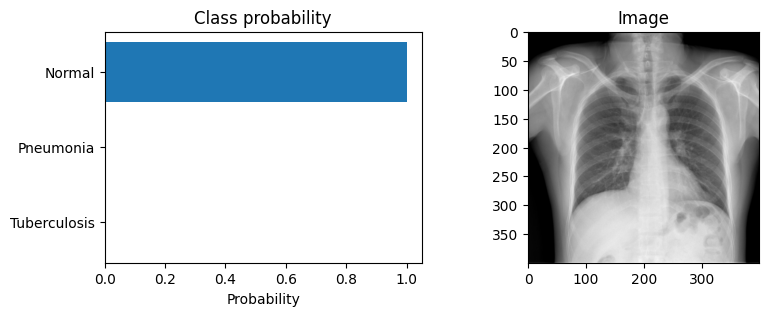

1/1 [==============================] - 0s 16ms/step


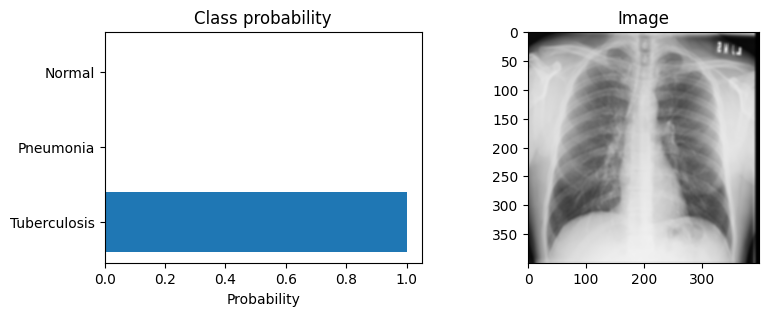

1/1 [==============================] - 0s 17ms/step


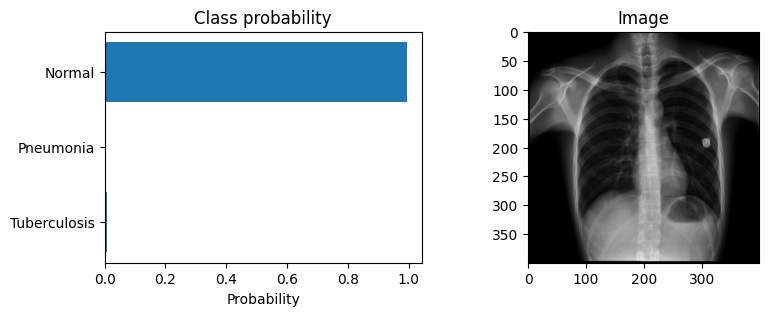

1/1 [==============================] - 0s 18ms/step


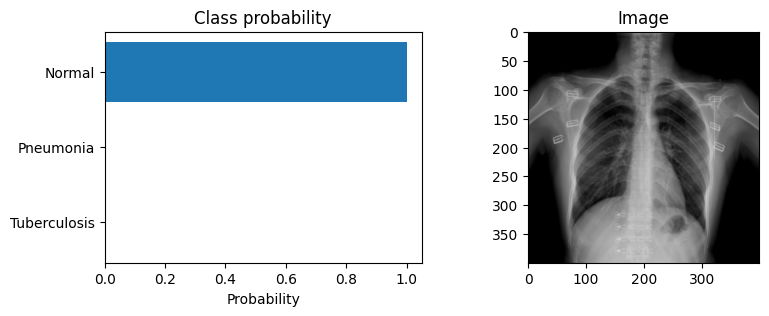

In [ ]:
test_path = datasetNameFolder + "/test/Normal" ##Choose from which folder do u want to analyse
#test_path = datasetNameFolder + "/test/Pneumonia" 
#test_path = datasetNameFolder + "/test/Tuberculosis"

i = 0
for files in listdir(test_path):
  
  img_path = os.path.join(test_path,files)
  img_original = mpimg.imread(img_path)
  img_np = image_to_np(img_path, IMG_SIZE)
  x = ['Normal', 'Pneumonia', 'Tuberculosis']
  y = model.predict(img_np)[0]  #produces an array [x,y,z] x = P(Normal), y = P(Pneumonia), z = P(Tuberculosis)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
  ax1.barh(x, y)
  ax1.invert_yaxis()  # labels read top-to-bottom
  ax1.set_xlabel('Probability')
  ax1.set_title('Class probability')
  ax2.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
  ax2.set_title('Image')
  plt.show()
  if i>=10:break
  i+=1

## 8.3 LIME

In [ ]:
!pip install --upgrade lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=437659851c993177e5e8e68431f4082bcc9992bcb7849b41f0317ed6e2a56753
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [ ]:
import lime
from lime import lime_image
from lime import submodular_pick
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Please don't remove these imports. It take me more than a hour to discover that removing it causes problems :()
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries
from skimage.segmentation import mark_boundaries

In [ ]:
def transform_image_lime(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    
    return img

def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    #plt.imshow(mark_boundaries(normalized_img[0], mask))
    #plt.axis('off')
    #plt.show()
    return mark_boundaries(normalized_img[0], mask)

def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    #plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    #plt.colorbar()
    #plt.show()
    return heatmap

In [ ]:
test_path = datasetNameFolder + "/test/Pneumonia" 

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8
i = 0
for files in listdir(test_path):
  
  img_path = os.path.join(test_path,files)
  img_array = preprocess_input(get_img_array(img_path, size=IMG_SIZE))
  
  # Read images
  img_original = mpimg.imread(img_path)

  # Normalize images
  normalized_img_lime = transform_image_lime(img_path, IMG_SIZE)
  normalized_img_lime = np.float64(normalized_img_lime) #transform to double because the library requires
  normalized_img = transform_image(img_path, IMG_SIZE)
  normalized_img = np.float64(normalized_img)

  # Calculate the explainer
  explainer = lime_image.LimeImageExplainer()
  exp = explainer.explain_instance(normalized_img_lime[0], 
                                 model.predict, 
                                 top_labels=5, 
                                 hide_color=0, 
                                 num_samples=100)

  # Plot
  print("\033[92m \033[1m Img Pneumonia: {} ↓ \033[0m".format(files))
  fig, ax = plt.subplots(1,3)
  ax[0].imshow(normalized_img[0])
  ax[0].set_xlabel('Original')
  ax[1].imshow(explanation_heatmap(exp, exp.top_labels[0]))
  ax[1].set_xlabel('Heatmap image')
  ax[2].imshow(generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False))
  ax[2].set_xlabel('Regions used for classification')
  fig.suptitle('Class: Pneumonia')
  plt.show()
  i += 1
  if i>120:break


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_path = datasetNameFolder + "/test/Tuberculosis" 

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8
i = 0
for files in listdir(test_path):
  
  img_path = os.path.join(test_path,files)
  img_array = preprocess_input(get_img_array(img_path, size=IMG_SIZE))
  
  # Read images
  img_original = mpimg.imread(img_path)

  # Normalize images
  normalized_img_lime = transform_image_lime(img_path, IMG_SIZE)
  normalized_img_lime = np.float64(normalized_img_lime) #transform to double because the library requires
  normalized_img = transform_image(img_path, IMG_SIZE)
  normalized_img = np.float64(normalized_img)

  # Calculate the explainer
  explainer = lime_image.LimeImageExplainer()
  exp = explainer.explain_instance(normalized_img_lime[0], 
                                 model.predict, 
                                 top_labels=5, 
                                 hide_color=0, 
                                 num_samples=100)

  # Plot
  print("\033[92m \033[1m Img Tuberculosis: {} ↓ \033[0m".format(files))
  fig, ax = plt.subplots(1,3)
  ax[0].imshow(normalized_img[0])
  ax[0].set_xlabel('Original')
  ax[1].imshow(explanation_heatmap(exp, exp.top_labels[0]))
  ax[1].set_xlabel('Heatmap image')
  ax[2].imshow(generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False))
  ax[2].set_xlabel('Regions used for classification')
  fig.suptitle('Class: Tuberculosis')
  plt.show()
  i += 1
  if i>100:break


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_path = datasetNameFolder + "/test/Normal" 

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8
i = 0
for files in listdir(test_path):
  
  img_path = os.path.join(test_path,files)
  img_array = preprocess_input(get_img_array(img_path, size=IMG_SIZE))
  
  # Read images
  img_original = mpimg.imread(img_path)

  # Normalize images
  normalized_img_lime = transform_image_lime(img_path, IMG_SIZE)
  normalized_img_lime = np.float64(normalized_img_lime) #transform to double because the library requires
  normalized_img = transform_image(img_path, IMG_SIZE)
  normalized_img = np.float64(normalized_img)

  # Calculate the explainer
  explainer = lime_image.LimeImageExplainer()
  exp = explainer.explain_instance(normalized_img_lime[0], 
                                 model.predict, 
                                 top_labels=5, 
                                 hide_color=0, 
                                 num_samples=100)

  # Plot
  print("\033[92m \033[1m Img Normal: {} ↓ \033[0m".format(files))
  fig, ax = plt.subplots(1,3)
  ax[0].imshow(normalized_img[0])
  ax[0].set_xlabel('Original')
  ax[1].imshow(explanation_heatmap(exp, exp.top_labels[0]))
  ax[1].set_xlabel('Heatmap image')
  ax[2].imshow(generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False))
  ax[2].set_xlabel('Regions used for classification')
  fig.suptitle('Class: Normal')
  plt.show()
  i += 1
  if i>100:break


Output hidden; open in https://colab.research.google.com to view.